In [131]:
import pandas as pd
import numpy as np
import jinja2
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [132]:
# read the csv file
path = r"C:\Users\Phili\Desktop\Data Exploration Project\EPL_Test_Repo\DataScienceProjects\data\history.csv"
# path = "preprocessed_dataframe_with_elo_1.csv"
match_data_unfiltered = pd.read_csv(path)

In [133]:
winning_team = match_data_unfiltered['FTR'].value_counts()
winning_team['H']/winning_team.sum()
# winning_team

0.4616100993377483

In [134]:
match_data_unfiltered = match_data_unfiltered[match_data_unfiltered['Season'].str.contains('201')]
match_data_unfiltered

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
6624,E0,14/08/10,Aston Villa,West Ham,3,0,H,2.0,0.0,H,2010-11
6625,E0,14/08/10,Blackburn,Everton,1,0,H,1.0,0.0,H,2010-11
6626,E0,14/08/10,Bolton,Fulham,0,0,D,0.0,0.0,D,2010-11
6627,E0,14/08/10,Chelsea,West Brom,6,0,H,2.0,0.0,H,2010-11
6628,E0,14/08/10,Sunderland,Birmingham,2,2,D,1.0,0.0,H,2010-11
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [135]:
# make FTR column to continous variable
# def convert_ftr(result: str):
#     if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
#     else: 
#         return None
# match_data_unfiltered['FTR'] = match_data_unfiltered['FTR'].apply(convert_ftr)

In [136]:
match_data_unfiltered = match_data_unfiltered.drop(["Unnamed: 0"], axis=1, errors="ignore")
# print(match_data_unfiltered.columns)
match_data_unfiltered.tail(n=5)

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18
9663,E0,13/05/18,West Ham,Everton,3,1,H,1.0,0.0,H,2017-18


In [137]:
# split train test data
# df_train = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 != 0]  # Excludes every 3rd row starting from 0
# df_test = match_data_unfiltered[match_data_unfiltered.reset_index().index % 3 == 0]  # Selects every 3rd row starting from 0
# match_data_unfiltered = df_train
df_test = match_data_unfiltered[match_data_unfiltered['Season']=='2017-18']
match_data_unfiltered = match_data_unfiltered[match_data_unfiltered['Season'].str.contains('201')]
df_test

,div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
9284,E0,11/8/2017,Arsenal,Leicester,4,3,H,2.0,2.0,D,2017-18
9285,E0,12/8/2017,Brighton,Man City,0,2,A,0.0,0.0,D,2017-18
9286,E0,12/8/2017,Chelsea,Burnley,2,3,A,0.0,3.0,A,2017-18
9287,E0,12/8/2017,Crystal Palace,Huddersfield,0,3,A,0.0,2.0,A,2017-18
9288,E0,12/8/2017,Everton,Stoke,1,0,H,1.0,0.0,H,2017-18
...,...,...,...,...,...,...,...,...,...,...,...
9659,E0,13/05/18,Newcastle,Chelsea,3,0,H,1.0,0.0,H,2017-18
9660,E0,13/05/18,Southampton,Man City,0,1,A,0.0,0.0,D,2017-18
9661,E0,13/05/18,Swansea,Stoke,1,2,A,1.0,2.0,A,2017-18
9662,E0,13/05/18,Tottenham,Leicester,5,4,H,1.0,2.0,A,2017-18


In [138]:
[match_data_unfiltered['Season'].str.contains('201')]

[6624    True
 6625    True
 6626    True
 6627    True
 6628    True
         ... 
 9659    True
 9660    True
 9661    True
 9662    True
 9663    True
 Name: Season, Length: 3040, dtype: bool]

max prob mit einem Testdatensatz von 50: 58% 
komplette halbe Saison: 64%

In [139]:
# print correlation matrix
correlation_matrix_match_data_unfiltered = match_data_unfiltered.corr()
correlation_matrix_match_data_unfiltered.style.background_gradient()

,FTHG,FTAG,HTHG,HTAG
FTHG,1.000000,-0.071370,0.682956,-0.061452
FTAG,-0.071370,1.000000,-0.074834,0.690473
HTHG,0.682956,-0.074834,1.000000,-0.070547
HTAG,-0.061452,0.690473,-0.070547,1.000000


In [140]:
history_pair_h = match_data_unfiltered.groupby(['HomeTeam', 'AwayTeam'])
ave_home_scored = history_pair_h['FTHG'].mean()
history_pair_a = match_data_unfiltered.groupby(['AwayTeam', 'HomeTeam'])
ave_away_scored = history_pair_a['FTAG'].mean()

ave_away_scored.keys()
ave_away_scored

AwayTeam  HomeTeam   
Arsenal   Aston Villa    2.166667
          Birmingham     3.000000
          Blackburn      2.500000
          Blackpool      3.000000
          Bolton         0.500000
                           ...   
Wolves    Swansea        4.000000
          Tottenham      1.000000
          West Brom      0.500000
          West Ham       0.000000
          Wigan          1.000000
Name: FTAG, Length: 950, dtype: float64

In [141]:
home = 'Arsenal'
t_ave_h_scored = ave_home_scored.loc[home].mean()
t_ave_h_scored

2.3679271708683474

In [142]:
def get_score(home, away, nsim):
    result = []
    try:
        ave_h_scored = ave_home_scored.loc[home, away]#, ave_away_scored.loc(away)}
        ave_a_scored = ave_away_scored.loc[away, home]
        for i in range(nsim):
            h_scored = poisson.rvs(1, ave_h_scored)
            a_scored = poisson.rvs(1, ave_a_scored)
            result.append([h_scored, a_scored])
        return result

    except:
        t_ave_h_scored = ave_home_scored.loc[home].mean()
        t_ave_h_conceded = ave_away_scored.loc[:, home].mean()
        t_ave_a_scored = ave_away_scored.loc[away].mean()
        t_ave_a_conceded = ave_home_scored.loc[:, away].mean()

        for i in range(nsim):
            h_scored = poisson.rvs(1, (t_ave_h_scored+t_ave_a_conceded)/2)
            a_scored = poisson.rvs(1, (t_ave_a_scored+t_ave_h_conceded)/2)
            result.append([h_scored, a_scored])
        return result

    # return ave_h_scored, ave_a_scored
score_arsenal_wh = get_score('West Ham','Arsenal', 1000)

In [143]:
# result = pd.DataFrame(columns=["Winner"])
def get_result_for_one_single_match(home_team, away_team):
    result = []
    for i in get_score(home_team, away_team, 10000):
        if i[0] > i[1]:
            result.append('H')
        elif i[0] == i[1]:
            result.append('D')
        else:
            result.append('A')
    home_win = result.count('H')/len(result)
    away_win = result.count('A')/len(result)
    draw = result.count('D')/len(result)
    alpha = 0.04
    print(f"Probability for home win: {home_win}, Away_win: {away_win}, draw: {draw}, Teams: {home_team, away_team}")
    return 'H' if home_win > away_win and home_win > (draw+alpha) else 'A' if away_win > (draw+alpha) else 'D' 

In [144]:
df_test['PredictedResult'] = None
# df_test[]
# df_test = df_test.tail(n=100)
for i in df_test.index:
    home_team = df_test['HomeTeam'][i]
    away_team = df_test['AwayTeam'][i]
    df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)

Probability for home win: 0.6487, Away_win: 0.1308, draw: 0.2205, Teams: ('Arsenal', 'Leicester')


C:\Users\Phili\AppData\Local\Temp/ipykernel_18828/1684315969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['PredictedResult'][i] = get_result_for_one_single_match(home_team, away_team)


Probability for home win: 0.039, Away_win: 0.8682, draw: 0.0928, Teams: ('Brighton', 'Man City')
Probability for home win: 0.6514, Away_win: 0.1271, draw: 0.2215, Teams: ('Chelsea', 'Burnley')
Probability for home win: 0.0071, Away_win: 0.9604, draw: 0.0325, Teams: ('Crystal Palace', 'Huddersfield')
Probability for home win: 0.6527, Away_win: 0.132, draw: 0.2153, Teams: ('Everton', 'Stoke')
Probability for home win: 0.6503, Away_win: 0.1329, draw: 0.2168, Teams: ('Southampton', 'Swansea')
Probability for home win: 0.6572, Away_win: 0.1275, draw: 0.2153, Teams: ('Watford', 'Liverpool')
Probability for home win: 0.3424, Away_win: 0.3522, draw: 0.3054, Teams: ('West Brom', 'Bournemouth')
Probability for home win: 0.8648, Away_win: 0.0384, draw: 0.0968, Teams: ('Man United', 'West Ham')
Probability for home win: 0.1308, Away_win: 0.6559, draw: 0.2133, Teams: ('Newcastle', 'Tottenham')
Probability for home win: 0.3464, Away_win: 0.3405, draw: 0.3131, Teams: ('Bournemouth', 'Watford')
Probab

In [145]:
# df_test['True'] = df_test[df_test['FTR']==df_test['PredictedResult']]
# df_test['True'].count_values()

In [146]:
len(df_test[df_test['FTR']==df_test['PredictedResult']])/len(df_test)

0.6447368421052632

In [147]:
df_test['FTR'].value_counts()

H    173
A    108
D     99
Name: FTR, dtype: int64

In [148]:
df_test['PredictedResult'].value_counts()

H    205
A    110
D     65
Name: PredictedResult, dtype: int64

In [149]:
df_test.to_csv("predicted_season_17-18_PL.csv")

In [150]:
# filter for specific columns
# match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeElo", "AwayElo", "HomeAttack", "HomeDefend", "AwayAttack", "AwayDefend"]]
# "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    # "AwayAttackOld", "AwayDefendOld"
# print correlation matrix
match_data_reduced = match_data_unfiltered.loc[:, ["FTR", "FTHG", "FTAG", "HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld", "AwayAttackOld", "AwayDefendOld"]]

correlation_matrix_match_data_reduced = match_data_reduced.corr()
correlation_matrix_match_data_reduced.style.background_gradient()

KeyError: "['HomeEloOld', 'AwayEloOld', 'HomeAttackOld', 'HomeDefendOld', 'AwayAttackOld', 'AwayDefendOld'] not in index"

In [ ]:
X = match_data_unfiltered.loc[:, ["HomeEloOld", "AwayEloOld", "HomeAttackOld", "HomeDefendOld",
    "AwayAttackOld", "AwayDefendOld"
]]

# use full time home goals and full time away goals; alternatively also using result directly is possible
y = match_data_unfiltered.loc[:, ["FTHG", "FTAG"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# X_train, y_train = X, y

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
# clf.predict(X_test)

In [ ]:
# result = clf.score(X_test, y_test)

In [ ]:
# result

In [ ]:
# class_names = {
#     'Away'
#     ,'Draw',
#     'Home'
# }
# # Plot non-normalized confusion matrix
# titles_options = [
#     ("Confusion matrix, without normalization", None),
#     ("Normalized confusion matrix", "true"),
# ]
# for title, normalize in titles_options:
#     disp = ConfusionMatrixDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         #display_labels=class_names,
#         cmap=plt.cm.Blues,
#         normalize=normalize,
#     )
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

# plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend, callbacks
#create model
model = Sequential()

#get number of columns in training data
n_cols_2 = X_train.shape[1]
print(n_cols_2)

#add layers to model
model.add(Dense(10, activation='relu', input_shape=(n_cols_2, )))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
# model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], metrics=['accuracy'])
model.compile(metrics=['accuracy'], optimizer='rmsprop', 
              loss='categorical_crossentropy')
# K.set_value(model.optimizer.learning_rate, 0.01)

# early_stopping_monitor = EarlyStopping(patience=3)

es = callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min',
                                   patience=10, 
                                   restore_best_weights=True) 


history = model.fit(X_train, y_train,  epochs=30, batch_size = 500, validation_split=0.3) #, callbacks=[early_stopping_monitor]) #callbacks=[es],

6
Epoch 1/30
5/5 [==============================] - 1s 35ms/step - loss: 402.3596 - accuracy: 0.7051 - val_loss: 357.4719 - val_accuracy: 0.6870
Epoch 2/30
5/5 [==============================] - 0s 6ms/step - loss: 337.3853 - accuracy: 0.7051 - val_loss: 313.5631 - val_accuracy: 0.6870
Epoch 3/30
5/5 [==============================] - 0s 7ms/step - loss: 297.0124 - accuracy: 0.7047 - val_loss: 277.0779 - val_accuracy: 0.6870
Epoch 4/30
5/5 [==============================] - 0s 8ms/step - loss: 264.0334 - accuracy: 0.7047 - val_loss: 250.6559 - val_accuracy: 0.6870
Epoch 5/30
5/5 [==============================] - 0s 8ms/step - loss: 244.5664 - accuracy: 0.7038 - val_loss: 234.8962 - val_accuracy: 0.6850
Epoch 6/30
5/5 [==============================] - 0s 7ms/step - loss: 230.3880 - accuracy: 0.7038 - val_loss: 225.9567 - val_accuracy: 0.6860
Epoch 7/30
5/5 [==============================] - 0s 7ms/step - loss: 221.2958 - accuracy: 0.7038 - val_loss: 214.3820 - val_accuracy: 0.6850
Epo

In [ ]:
model.evaluate(X_test, y_test)

51/51 [==============================] - 0s 1ms/step - loss: 36.2927 - accuracy: 0.6658


[36.29267501831055, 0.6658415794372559]

In [ ]:
test = model.predict(X_test)
winning_team = []
for item in test:
    if abs(item[0]-item[1]) < 0.5:
        winning_team.append(2)
    elif item[0] > item[1]:
        winning_team.append(3)
    else:
        winning_team.append(1)
#   if result == "D":
#         return 2
#     elif result == "H":
#         return 3
#     elif result == "A":
#         return 1
winning_team.count(2)

110

In [ ]:
winning_team_test = []
for item in np.array(y_test):
    if item[0] > item[1]:
        winning_team_test.append(3)
    elif item[0] == item[1]:
        winning_team_test.append(2)
    else:
        winning_team_test.append(1)
len(winning_team)

1616

In [ ]:
y_test
test

array([[5.9379882e-01, 4.0620115e-01],
       [9.9743962e-01, 2.5604034e-03],
       [1.0496547e-09, 1.0000000e+00],
       ...,
       [1.7012398e-14, 1.0000000e+00],
       [2.0263379e-07, 9.9999976e-01],
       [1.5396611e-01, 8.4603387e-01]], dtype=float32)

In [ ]:
counter = 0
for i in range(len(winning_team)):
    if winning_team[i] == winning_team_test[i]:
        counter += 1
counter/len(winning_team)

0.4801980198019802

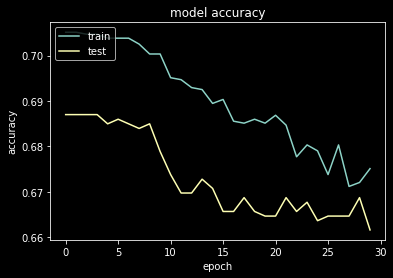

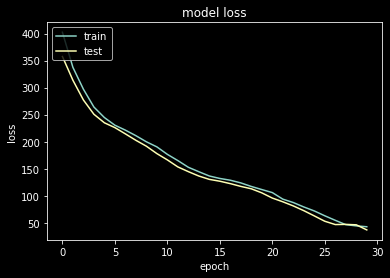

In [ ]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()

# summarize history for loss

plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')

plt.show()